In [46]:
import numpy as np
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import learning_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def bunch_to_dataframe(bunch):
  fnames = bunch.feature_names
  features = fnames.tolist() if isinstance(fnames, np.ndarray) else fnames
  features += ['target']
  return pd.DataFrame(data= np.c_[bunch['data'], bunch['target']],
                 columns=features)

In [31]:
bc = load_breast_cancer()
data = bunch_to_dataframe(bc)

### Exploración de los datos

In [32]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


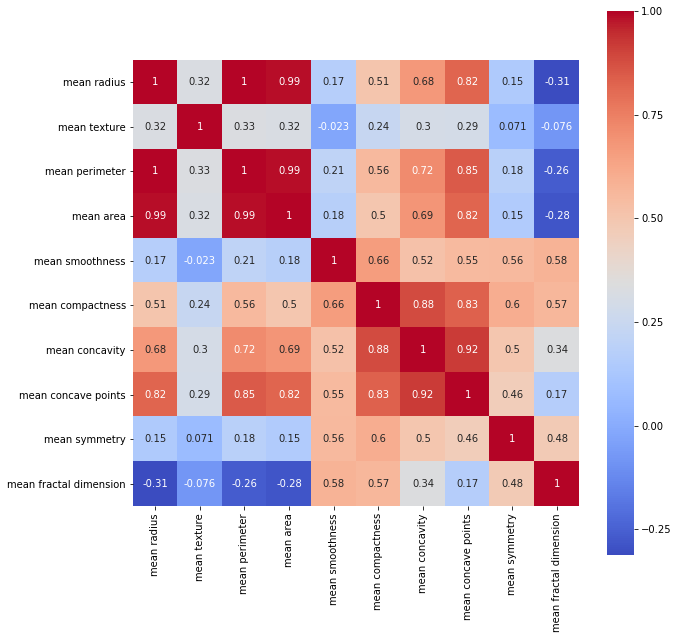

In [33]:
features_mean= list(data.columns[0:10])
plt.figure(figsize=(10,10))
sns.heatmap(data[features_mean].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

/Users/borjaeg/anaconda3/envs/iaaa_agriculture/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


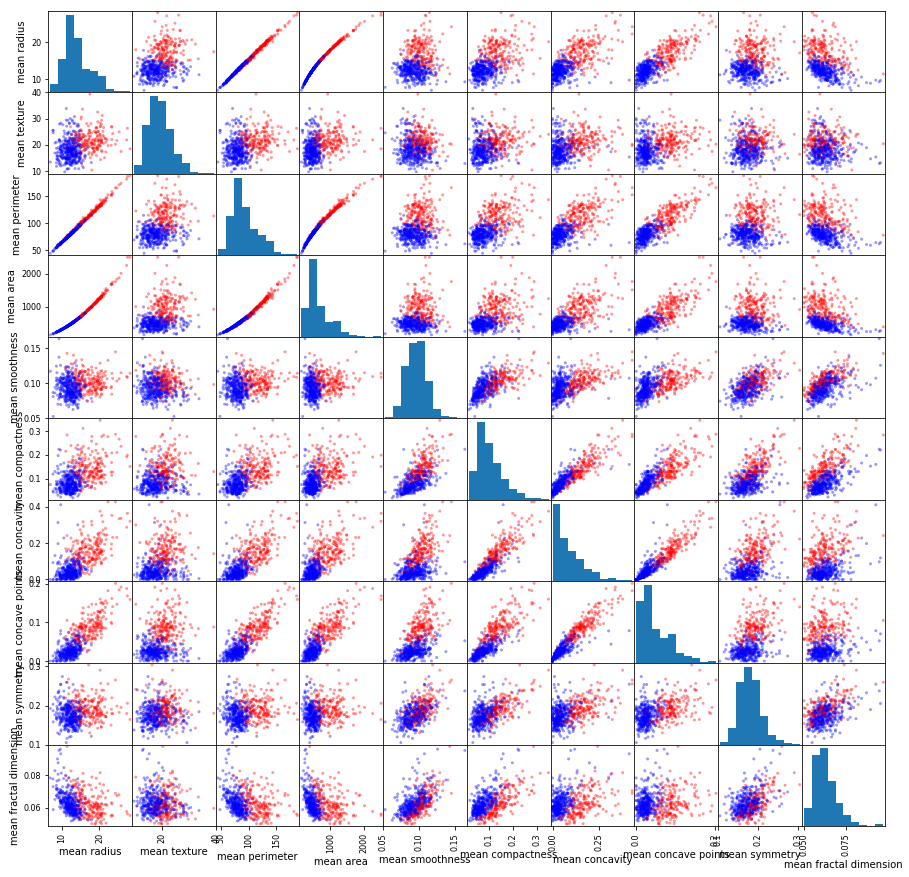

In [34]:
color_dic = {1.0:'red', 0.0:'blue'}
colors = data['target'].map(lambda x: color_dic.get(x))

sm = pd.scatter_matrix(data[features_mean], c=colors, alpha=0.4, figsize=((15,15)))

plt.show()

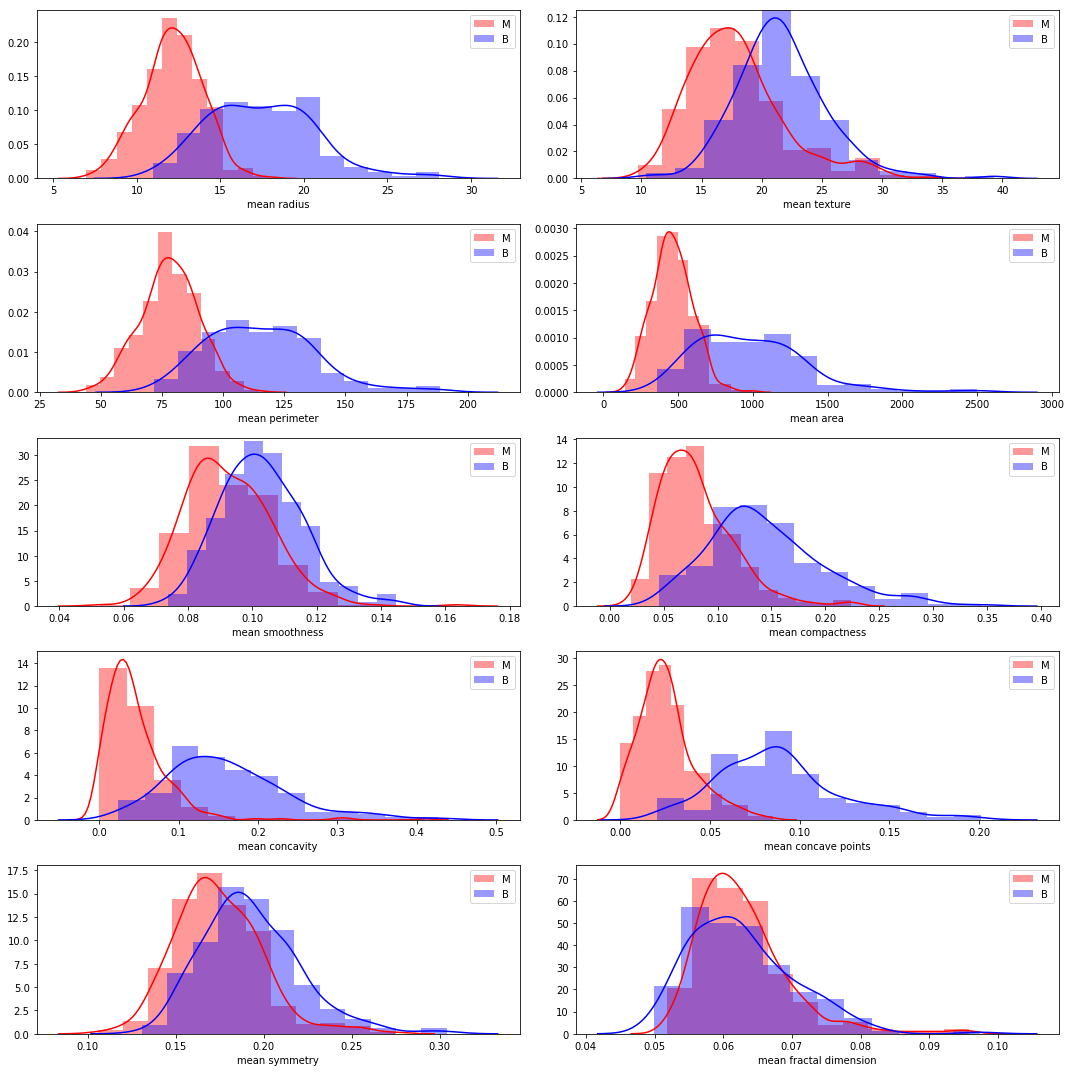

In [37]:
bins = 12
plt.figure(figsize=(15,15))
rows = int(len(features_mean)/2)
for i, feature in enumerate(features_mean):
    
    plt.subplot(rows, 2, i+1)
    
    sns.distplot(data[data['target']==1.0][feature], bins=bins, color='red', label='M');
    sns.distplot(data[data['target']==0.0][feature], bins=bins, color='blue', label='B');
    
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

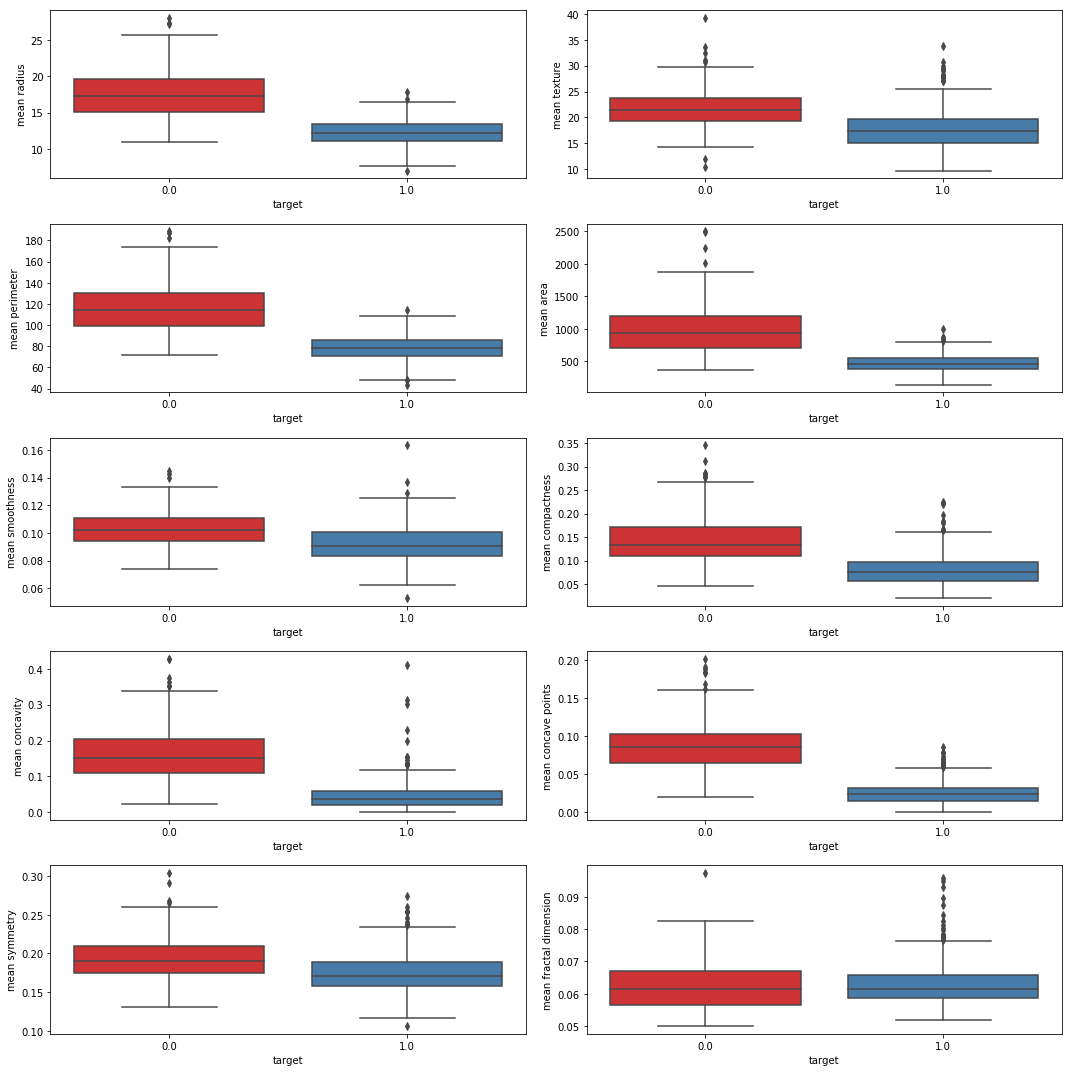

In [38]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(features_mean):
    rows = int(len(features_mean)/2)
    
    plt.subplot(rows, 2, i+1)
    
    sns.boxplot(x='target', y=feature, data=data, palette="Set1")

plt.tight_layout()
plt.show()

### Machine Learning

In [39]:
X, y = load_breast_cancer(return_X_y=True)

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3)):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim([0.8, 1.01])
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc='lower right')
    plt.show()

In [41]:
def plot_roc_curves(results, y_test):
    
    colors = ['r', 'g', 'b', 'y']
    
    plt.figure(figsize=(6, 6))
    for i, result in enumerate(results):
        name = result[0]
        predictions = result[1][:,1]
        fpr, tpr, _ =  roc_curve(y_test, predictions)
        auc_score = auc(fpr, tpr)
        label = name + ' AUC={0:0.2f}'.format(auc_score)
        plt.plot(fpr, tpr, color = colors[i], lw = 2, label = label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.ylim([0.6, 1.05])
        plt.xlim([0.0, 0.8])
        plt.legend(loc='lower right')
    plt.title('ROC curve')
    plt.show()

In [42]:
def plot_precision_recall_curves(results, y_test):
    
    colors = ['r', 'g', 'b', 'y']
    
    plt.figure(figsize=(6, 6))
    for i, result in enumerate(results):
        name = result[0]
        predictions = result[1][:,1]
        aps = average_precision_score(y_test, predictions)
        precision, recall, _ =  precision_recall_curve(y_test, predictions)
        label = name + ' AP={0:0.2f}'.format(aps)
        plt.plot(recall, precision, color = colors[i], lw = 2, label = label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.7, 1.05])
        plt.xlim([0.0, 1.05])
        plt.legend(loc='lower right')
    plt.title('Precision-Recall curve')
    plt.show()

In [43]:
def get_best_estimator(estimator, X_train, y_train):
    param_grid = {}
    param_grid["SVC"] = {'sel__k': [10, 20, 30], 
                         'clf__C': [1, 100, 1000], 
                         'clf__kernel': ['linear', 'rbf', 'poly']}
    param_grid["NB"] = {'sel__k': [10, 20, 30]}
    param_grid["Log"] = {'sel__k': [10, 20, 30],
                         'clf__C': [1, 100, 1000]}
    param_grid["RF"] = {'sel__k': [10, 20, 30],
                        'clf__n_estimators': [10, 20, 50, 100]}
    param_grid["KNN"] = {'sel__k': [10, 20, 30],
                        'clf__n_neighbors': [3, 5, 10]}
    
    name = estimator[0]
    pipe = estimator[1]
    
    grid = GridSearchCV(pipe, cv=5, n_jobs=-1, refit = True,
                        param_grid=param_grid[name],
                        scoring = 'accuracy')
    
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()
    print("Time: %.2f sec" % (end - start))
    
    print("Best Parameters")
    print(grid.best_params_)
    return grid.best_estimator_
    

In [57]:
def experiment():
    estimators = [
                   ("NB", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", GaussianNB())])),
                   ("Log", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", LogisticRegression())])),
                   ("RF", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", RandomForestClassifier())])),
                   ("KNN", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", KNeighborsClassifier())])),
#                    ("SVC", 
#                       Pipeline([
#                           ('sel', SelectKBest()),
#                           ("clf",SVC(probability = True))]))
                  ]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                        stratify=y, shuffle=True)

    results = []

    for estimator in estimators:
        print(estimator[0])
        best_estimator = get_best_estimator(estimator, X_train, y_train)

        predictions = best_estimator.predict(X_test)
        print(classification_report(y_test, predictions))
        results.append((estimator[0], best_estimator.predict_proba(X_test)))
        scores = cross_val_score(best_estimator, X_test, y_test, cv=5)
        print("Accuracy: %.2f%% (+/- %.2f)"% (np.mean(scores), np.std(scores)))
        plot_learning_curve(best_estimator, "Learning Curve " + estimator[0], 
                        X_train, y_train, ylim=None, cv=3,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        print("="*20)
    plot_precision_recall_curves(results, y_test)
    print("="*20)
    plot_roc_curves(results, y_test)

NB
Time: 0.27 sec
Best Parameters
{'sel__k': 20}
             precision    recall  f1-score   support

          0       0.98      0.86      0.92        70
          1       0.92      0.99      0.96       118

avg / total       0.94      0.94      0.94       188

Accuracy: 0.93% (+/- 0.03)


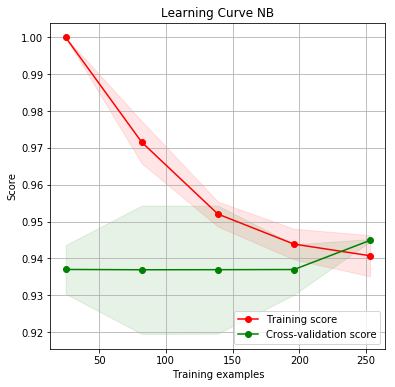

Log
Time: 0.37 sec
Best Parameters
{'clf__C': 100, 'sel__k': 30}
             precision    recall  f1-score   support

          0       0.94      0.93      0.94        70
          1       0.96      0.97      0.96       118

avg / total       0.95      0.95      0.95       188

Accuracy: 0.94% (+/- 0.04)


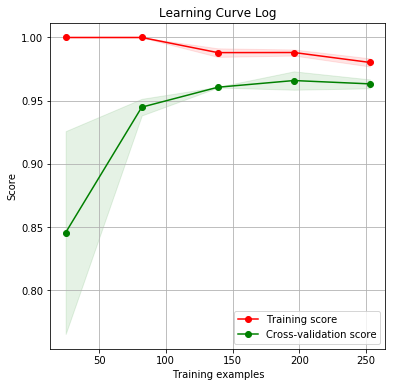

RF
Time: 2.24 sec
Best Parameters
{'clf__n_estimators': 20, 'sel__k': 20}
             precision    recall  f1-score   support

          0       0.93      0.91      0.92        70
          1       0.95      0.96      0.95       118

avg / total       0.94      0.94      0.94       188

Accuracy: 0.94% (+/- 0.05)


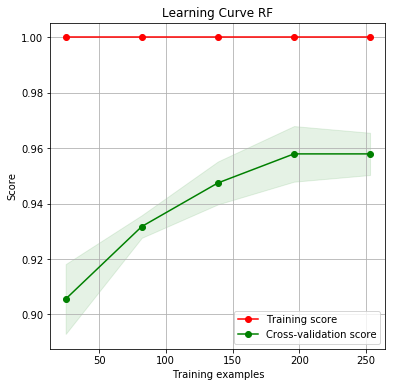

KNN
Time: 0.35 sec
Best Parameters
{'clf__n_neighbors': 5, 'sel__k': 20}
             precision    recall  f1-score   support

          0       0.91      0.90      0.91        70
          1       0.94      0.95      0.95       118

avg / total       0.93      0.93      0.93       188

Accuracy: 0.95% (+/- 0.04)


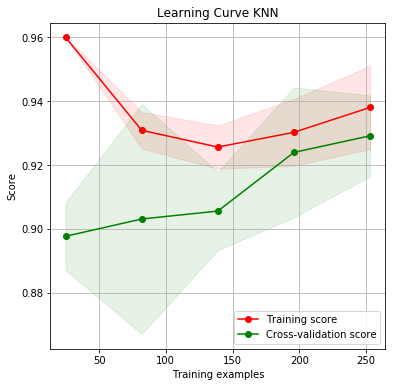

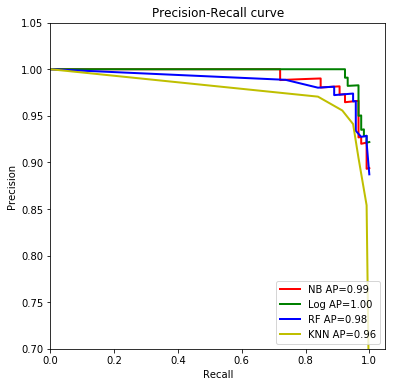

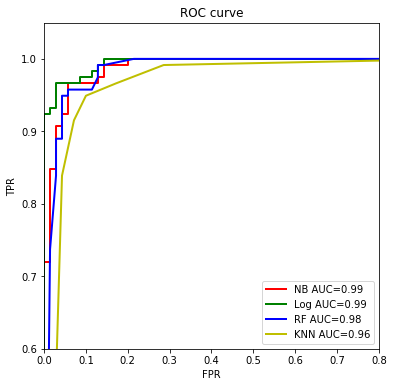

In [58]:
experiment()